# Proyek Klasifikasi Gambar: [Animals]
- Nama: [Maklon Jaco Frare]
- Email: [maklonjacob.frare@gmail.com]
- ID Dicoding: [maklon]

# 1. Import Semua Packages/Library yang Digunakan



In [2]:
# Library manipulasi file, manipulasi data, dan pustaka visualisasi
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq


In [3]:
# Library pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
# Library pengembangan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
# Library Penanganan Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#!pip install tensorflow==2.15.1

In [ ]:
#!pip install tensorflowjs

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.1


## Data Preparation

### Data Loading

#### 1. Download Dataset dan Extrak Dataset

In [7]:
# Upload file dengan google colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maklonfr","key":"1a49c15e7a437b87a9d64a73cad0364e"}'}

In [8]:
# Download dataset dari kaggle
!kaggle datasets download -d antobenedetti/animals

Dataset URL: https://www.kaggle.com/datasets/antobenedetti/animals
License(s): GPL-2.0
100% 880M/882M [00:03<00:00, 243MB/s]
100% 882M/882M [00:03<00:00, 242MB/s]


In [9]:
# Ekstrak dataset yang didownload
!unzip animals.zip

Streaming output truncated to the last 5000 lines.
  inflating: animals/train/horse/horse2690.jpg  
  inflating: animals/train/horse/horse2691.jpg  
  inflating: animals/train/horse/horse2692.jpg  
  inflating: animals/train/horse/horse2693.jpg  
  inflating: animals/train/horse/horse2694.jpg  
  inflating: animals/train/horse/horse2695.jpg  
  inflating: animals/train/horse/horse2696.jpg  
  inflating: animals/train/horse/horse2697.jpg  
  inflating: animals/train/horse/horse2698.jpg  
  inflating: animals/train/horse/horse2699.jpg  
  inflating: animals/train/horse/horse27.jpg  
  inflating: animals/train/horse/horse270.jpg  
  inflating: animals/train/horse/horse2701.jpg  
  inflating: animals/train/horse/horse2702.jpg  
  inflating: animals/train/horse/horse2703.jpg  
  inflating: animals/train/horse/horse2704.jpg  
  inflating: animals/train/horse/horse2705.jpg  
  inflating: animals/train/horse/horse2706.jpg  
  inflating: animals/train/horse/horse2707.jpg  
  inflating: animals/

#### 2. Menentukan Direktori Awal Data Train-Test serta Data Gabungan keduanya

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
# Direktori Awal untuk Train & Test
train_direct = "animals/train"
test_direct  = "animals/val"

# Direktori Gabungan Train-Test
join_dir = "animals/dataset"

In [12]:
# Membuat directory gabungan dengan perintah os.makedirs()
os.makedirs(join_dir, exist_ok=True)

In [13]:
# mengganti nama file dataset pada directori val
for category in os.listdir(test_direct):
    category_dir = os.path.join(test_direct, category)
    # Loop melalui semua file dalam folder
    for filename in os.listdir(category_dir):
        # Tentukan path file lama
        old_file_path = os.path.join(category_dir, filename)

        # Tentukan nama file baru (misalnya, menambahkan prefix 'new_')
        new_filename = '000_' + filename
        new_file_path = os.path.join(category_dir, new_filename)

        # Ganti nama file
        os.rename(old_file_path, new_file_path)

print('Semua file dalam folder berhasil diganti namanya.')

Semua file dalam folder berhasil diganti namanya.


#### 3. Menyalin file dan folder dataset dari directory train dan test ke dalam directory dataset yang telah dibuat

In [14]:
# Salin file dan folder dari train
for category in os.listdir(train_direct):
    category_dir = os.path.join(train_direct, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(join_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_direct):
    category_dir = os.path.join(test_direct, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(join_dir, category), dirs_exist_ok=True)

In [15]:
# cek jumlah file dataset
folder_path = join_dir
sum_num_files = 0
for category in os.listdir(folder_path):
    category_dir = os.path.join(folder_path, category)
    num_files = len(os.listdir(category_dir))
    print(f'Jumlah file dalam folder "{category_dir}" adalah: {num_files}')
    sum_num_files = sum_num_files + num_files
print(f'Jumlah file dalam folder "{folder_path}" adalah: {sum_num_files}')

Jumlah file dalam folder "animals/dataset/dog" adalah: 2927
Jumlah file dalam folder "animals/dataset/horse" adalah: 3005
Jumlah file dalam folder "animals/dataset/lion" adalah: 2973
Jumlah file dalam folder "animals/dataset/cat" adalah: 3037
Jumlah file dalam folder "animals/dataset/elephant" adalah: 3029
Jumlah file dalam folder "animals/dataset" adalah: 14971


### Data Preprocessing

#### 1. Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih

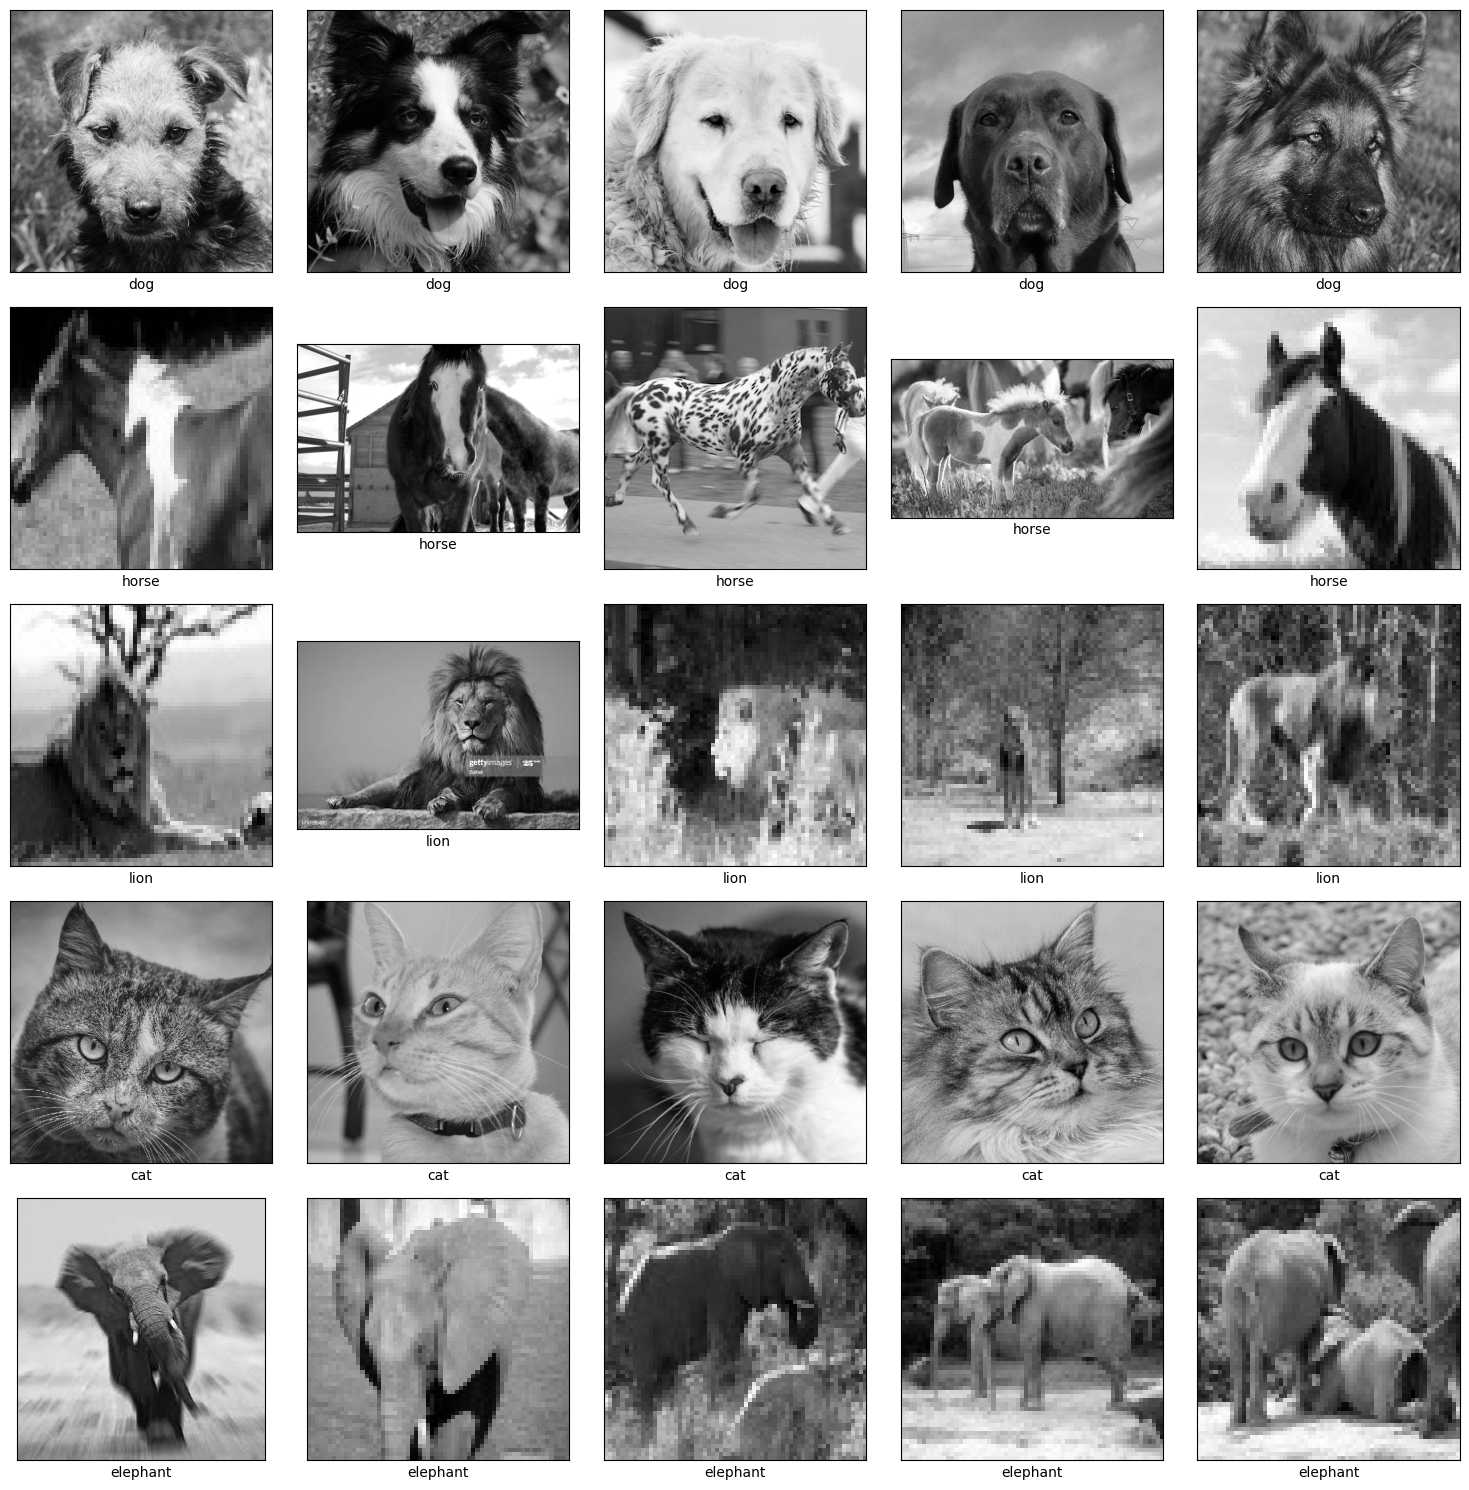

In [16]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "animals/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "animals/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

#### 2. Menampilkan Plot Distribusi Dataset

In [17]:
def plot_distribution ():
  # Definisikan path sumber
  source_path = "animals/dataset/"
  # Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
  file_name = []
  labels = []
  full_path = []

  # Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
  for path, subdirs, files in os.walk(source_path):
      for name in files:
          full_path.append(os.path.join(path, name))
          labels.append(path.split('/')[-1])
          file_name.append(name)

  distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "Animals":labels})

  # Plot distribusi gambar di setiap kelas
  animal_name = distribution_train['Animals']
  plt.figure(figsize = (6,6))
  plt.title('Animals Plot Distribution')
  sns.set_style("darkgrid")
  sns.set_palette("Set3")
  sns.set_context("notebook")
  plot_data = sns.countplot(animal_name)

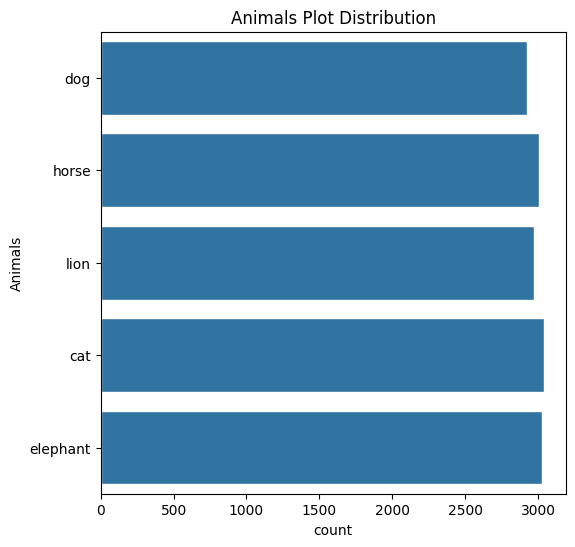

In [18]:
# Panggil fungsi plot distribution
plot_distribution()

#### 3. Proses Augmentation Dataset

In [19]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    sudut = random.randint(0,180)
    return rotate(animal_image, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    sudut = random.randint(0,180)
    return rotate(animal_image, -sudut)

# Melakukan rotasi rotasi secara acak
def random_rotation(animal_image, angle_range=(-20, 20)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    h, w = animal_image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(animal_image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)
    return rotated_image

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    return np.flipud(animal_image)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    animal_image = adjust_gamma(animal_image, gamma=0.5,gain=1)
    return animal_image

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    return cv2.GaussianBlur(animal_image, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(animal_image, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(animal_image):
    animal_image = cv2.cvtColor(animal_image, 0)
    animal_image = cv2.resize(animal_image, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(animal_image, transform, mode="wrap")
    return warp_image

In [20]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'random rotation' : random_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

for x in range(2):
  if (x == 0):
    images_path= join_dir + "/lion"
    augmented_path= join_dir + "/lion"
    images_to_generate=30
  if (x == 1):
    images_path= join_dir + "/dog"
    augmented_path= join_dir + "/dog"
    images_to_generate=80

  # Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
  for im in os.listdir(images_path):
      images.append(os.path.join(images_path,im))
  i=1
  while i<=images_to_generate:
      image=random.choice(images)
      try:
          original_image = io.imread(image)
          transformed_image=None
          n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
          transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

          while n <= transformation_count:
              key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
              transformed_image = transformations[key](original_image)
              n = n + 1

          new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
          transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
          cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
          i =i+1
      except ValueError as e:
          print('could not read the',image ,':',e,'hence skipping it.')

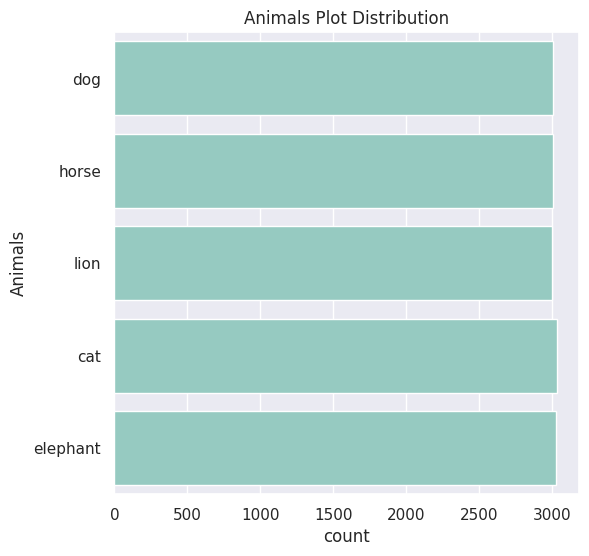

In [21]:
# Panggil fungsi plot distribution
plot_distribution()

### Split Dataset

In [24]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= "animals/dataset/"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"animals-label":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['animals-label']).size()

,0
animals-label,
cat,3037
dog,3007
elephant,3029
horse,3005
lion,3003


In [25]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['animals-label']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [26]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'animals-label':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'animals-label':y_test,'set':'val'})

In [27]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'animals-label']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "animals/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/content/drive/MyDrive/ml_intermediate/dataset-final/"


set    animals-label
train  cat              2424
       dog              2422
       elephant         2395
       horse            2440
       lion             2383
val    cat               613
       dog               585
       elephant          634
       horse             565
       lion              620
dtype: int64 


                                          path animals-label    set
235   animals/dataset/elephant/elephant375.jpg      elephant  train
7679             animals/dataset/cat/cat51.jpg           cat  train
1341        animals/dataset/dog/000_dog216.jpg           dog  train
4487         animals/dataset/lion/lion1250.jpg          lion  train
181            animals/dataset/cat/cat1382.jpg           cat  train


In [28]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['animals-label'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['animals-label'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['animals-label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['animals-label'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [29]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/drive/MyDrive/ml_intermediate/dataset-final/val'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"animals-label":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['animals-label']).size()

,0
animals-label,
cat,613
dog,585
elephant,634
horse,565
lion,620


#### Image Data Generator

In [30]:
# Definisikan direktori training dan test
folder_path_train = '/content/drive/MyDrive/ml_intermediate/dataset-final/train'
folder_path_test = '/content/drive/MyDrive/ml_intermediate/dataset-final/val'

# menghitung jumlah gambar pada setiap kategori pada directori train
sum_num_files = 0
for category_dir_two in os.listdir(folder_path_train):
  category_dir = os.path.join(folder_path_train, category_dir_two)
  num_files = len(os.listdir(category_dir))
  print(f'Jumlah file dalam folder "{category_dir}" adalah: {num_files}')
  sum_num_files = sum_num_files + num_files
print(f'Jumlah file dalam folder "{folder_path_train}" adalah: {sum_num_files}')

# menghitung jumlah gambar pada setiap kategori pada directori test
sum_num_files = 0
for category_dir_one in os.listdir(folder_path_test):
    category_dir = os.path.join(folder_path_test, category_dir_one)
    num_files = len(os.listdir(category_dir))
    print(f'Jumlah file dalam folder "{category_dir}" adalah: {num_files}')
    sum_num_files = sum_num_files + num_files
print(f'Jumlah file dalam folder "{folder_path_test}" adalah: {sum_num_files}')

Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/train/cat" adalah: 2424
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/train/dog" adalah: 2422
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/train/lion" adalah: 2383
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/train/horse" adalah: 2440
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/train/elephant" adalah: 2395
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/train" adalah: 12064
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/val/dog" adalah: 585
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/val/cat" adalah: 613
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-final/val/lion" adalah: 620
Jumlah file dalam folder "/content/drive/MyDrive/ml_intermediate/dataset-fin

In [31]:
# setup imageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    zoom_range=0.2,
    horizontal_flip=True
)

val_generator = ImageDataGenerator(
    rescale=1./255
)

# Membagi menjadi data uji dan data validasi
train_images = train_generator.flow_from_directory(
    folder_path_train,
    target_size=(64,64),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_images = val_generator.flow_from_directory(
    folder_path_test,
    target_size=(64,64),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 12064 images belonging to 5 classes.
Found 3017 images belonging to 5 classes.


## Modelling

In [32]:
# Membuat Model CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3), kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    layers.Dense(5, activation='softmax')
])

In [33]:
# setup learning rate dan early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", mode='min', min_delta=0.1, patience=10, restore_best_weights=True)

# Determine Optimizer & Loss Function
model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                        

In [34]:
# Train model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=30,
                    callbacks=[early_stopping,reduce_lr],
                    verbose=1)

Epoch 1/30
189/189 [==============================] - 244s 1s/step - loss: 8.4429 - accuracy: 0.6692 - val_loss: 3.6026 - val_accuracy: 0.2055 - lr: 0.0010
Epoch 2/30
189/189 [==============================] - 249s 1s/step - loss: 1.6561 - accuracy: 0.7780 - val_loss: 2.1265 - val_accuracy: 0.3845 - lr: 0.0010
Epoch 3/30
189/189 [==============================] - 233s 1s/step - loss: 1.1502 - accuracy: 0.8060 - val_loss: 2.0392 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 4/30
189/189 [==============================] - 248s 1s/step - loss: 1.0039 - accuracy: 0.8192 - val_loss: 0.9655 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 5/30
189/189 [==============================] - 235s 1s/step - loss: 0.9394 - accuracy: 0.8263 - val_loss: 1.1852 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 6/30
189/189 [==============================] - ETA: 0s - loss: 0.9143 - accuracy: 0.8361
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
189/189 [==============================] - 233s 

## Evaluasi dan Visualisasi

In [35]:
# Evaluasi model
loss, accuracy = model.evaluate(val_images)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

48/48 [==============================] - 34s 700ms/step - loss: 0.4838 - accuracy: 0.9155
Validation Accuracy: 91.55%


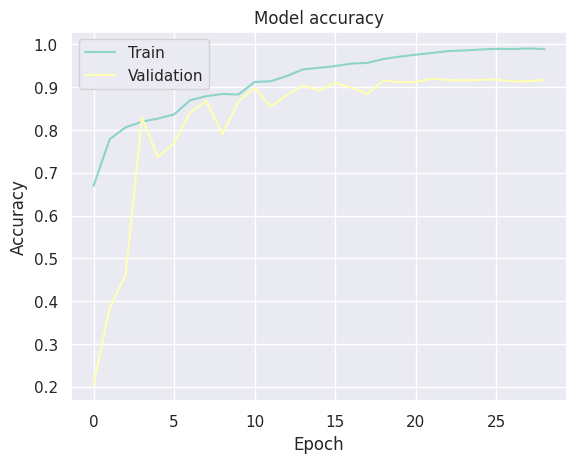

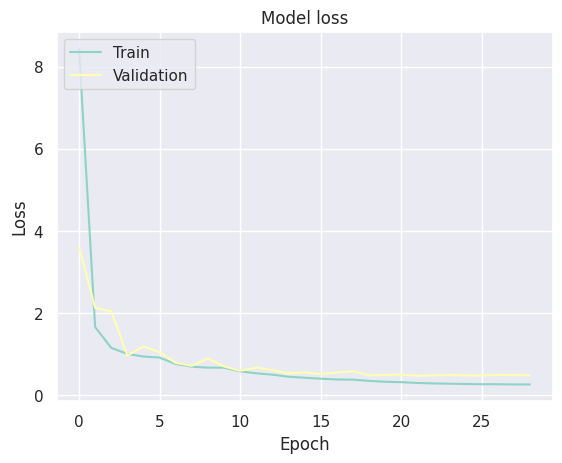

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Konversi Model

In [37]:
# Menyimpan model dalam format SavedModel (h5)
model.save("/content/drive/MyDrive/ml_intermediate/cnn_image_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
# Menyimpan model dalam format SavedModel (direkomendasikan)
tf.saved_model.save(model, "/content/drive/MyDrive/ml_intermediate/cnn_image_classification")

In [39]:
# Mengonversi model yang disimpan dalam format SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/ml_intermediate/cnn_image_classification")
tflite_model = converter.convert()

# Menyimpan model yang dikonversi ke file .tflite
with open("/content/drive/MyDrive/ml_intermediate/cnn_image_classification.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
#!pip install tensorflowjs

In [1]:
!tensorflowjs_converter --input_format=keras /content/drive/MyDrive/ml_intermediate/cnn_image_classification.h5 /content/drive/MyDrive/ml_intermediate/tfjs_model

2024-08-19 16:22:38.133748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 16:22:38.165592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 16:22:38.165670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 16:22:38.184695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 16:22:39.892198: W tensorflow/compiler/tf

## Inference (Optional)

In [2]:
!pip freeze > all_requirements.txt

In [3]:
required_packages = [
    "pathlib",
    "scikit-learn",
    "pandas",
    "numpy",
    "matplotlib",
    "keras",
]

# Library reading
with open("all_requirements.txt", "r") as file:
    lines = file.readlines()

# library filtering
with open("requirements.txt", "w") as file:
    for line in lines:
        package_name = line.split("==")[0]
        if package_name in required_packages:
            file.write(line)
# finishing
with open("requirements.txt", "r") as file:
    requirements = file.read()
print(requirements)

keras==3.5.0
matplotlib==3.7.1
numpy==1.26.4
pandas==2.1.4
pathlib==1.0.1
scikit-learn==1.3.2

